### Setup and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor

sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*")



In [2]:
DATA_PATH = "/content/sample_data/Australian Vehicle Prices.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


### Initial data inspection

In [3]:
df.info()
df.describe(include="all").T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,16733,76,Toyota,2784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,16733.0,NaN,NaN,NaN,2016.229248,5.247705,1940.0,2013.0,2017.0,2020.0,2023.0
Model,16733,781,Hilux,430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Car/Suv,16706,618,SUV,5921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title,16733,8804,2019 Hyundai I30 Active,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsedOrNew,16733,3,USED,14994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,16733,3,Automatic,14530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,16733,106,"4 cyl, 2 L",3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DriveType,16733,5,Front,6978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FuelType,16733,9,Unleaded,6985,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Key comments:

-Mixed numeric + text fields <br>
-Kilometres, Price stored as strings <br>
-High-cardinality Brand / Model <br>
-Significant outliers

### Core Feature Engineering

In [4]:
df["Age"] = 2023 - df["Year"]
df["Kilometres"] = pd.to_numeric(df["Kilometres"], errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["age_kilometer_interaction"] = (df["Age"] * df["Kilometres"]) / 10000
df["km_per_year"] = df["Kilometres"] / (df["Age"] + 1)


### Extract numeric values

In [5]:
df["Seats"] = df["Seats"].astype(str).str.extract(r"(\d+)").fillna(0).astype(int)
df["FuelConsumption"] = df["FuelConsumption"].astype(str).str.extract(r"(\d+\.?\d*)").astype(float)
df["FuelConsumption"] = df["FuelConsumption"].fillna(df["FuelConsumption"].median())
df["CylindersinEngine"] = df["CylindersinEngine"].astype(str).str.extract(r"(\d+)").fillna(0).astype(int)

#### Mapping

In [6]:
transmission_map = {"Manual": 0, "Automatic": 1}
fuel_map = {"Gasoline": 0, "Unleaded": 0, "Premium": 0, "Diesel": 1, "Electric": 2, "Hybrid": 3}
df["Transmission"] = df["Transmission"].map(transmission_map).fillna(-1).astype(int)
df["FuelType"] = df["FuelType"].map(fuel_map).fillna(-1).astype(int)

### Age km Interaction

In [7]:
df["age_kilometer_interaction"] = (df["Age"] * df["Kilometres"]) / 10000

### Filtering & Frequency Thresholds

In [8]:
# Remove extreme outliers and focus on high-volume data
df = df[(df["Price"] > 1000) & (df["Price"] <= 200000) &
        (df["Kilometres"] <= 200000) & (df["Year"] >= 2000)].copy()

brands_to_keep = df["Brand"].value_counts()[lambda x: x >= 100].index
df = df[df["Brand"].isin(brands_to_keep)]

model_counts = df.groupby(["Brand", "Model"]).size().reset_index(name="n")
models_to_keep = model_counts[model_counts["n"] >= 50][["Brand", "Model"]]
df = df.merge(models_to_keep, on=["Brand", "Model"])

### Price Anchoring & Target

In [9]:

# Define "New Price" as the 95th percentile price for cars with < 10k km
near_new = df[df["Kilometres"] <= 10000]

# Calculate proxies
new_price_bm = near_new.groupby(["Brand", "Model"])["Price"].quantile(0.95).rename("New_Price_bm").reset_index()
new_price_b = near_new.groupby("Brand")["Price"].quantile(0.95).rename("New_Price_b").reset_index()

# Merge back to main dataframe
df = df.merge(new_price_bm, on=["Brand", "Model"], how="left")
df = df.merge(new_price_b, on="Brand", how="left")

# Fill missing model-specific prices with brand-level averages
df["New_Price"] = df["New_Price_bm"].fillna(df["New_Price_b"])
df = df[df["New_Price"].notna()].copy()

# Target Variables
df["retention"] = (df["Price"] / df["New_Price"]).clip(0.02, 1.3)
df["y"] = np.log(df["retention"])
df["log_km"] = np.log1p(df["Kilometres"])

## EDA

### Distribution Checks

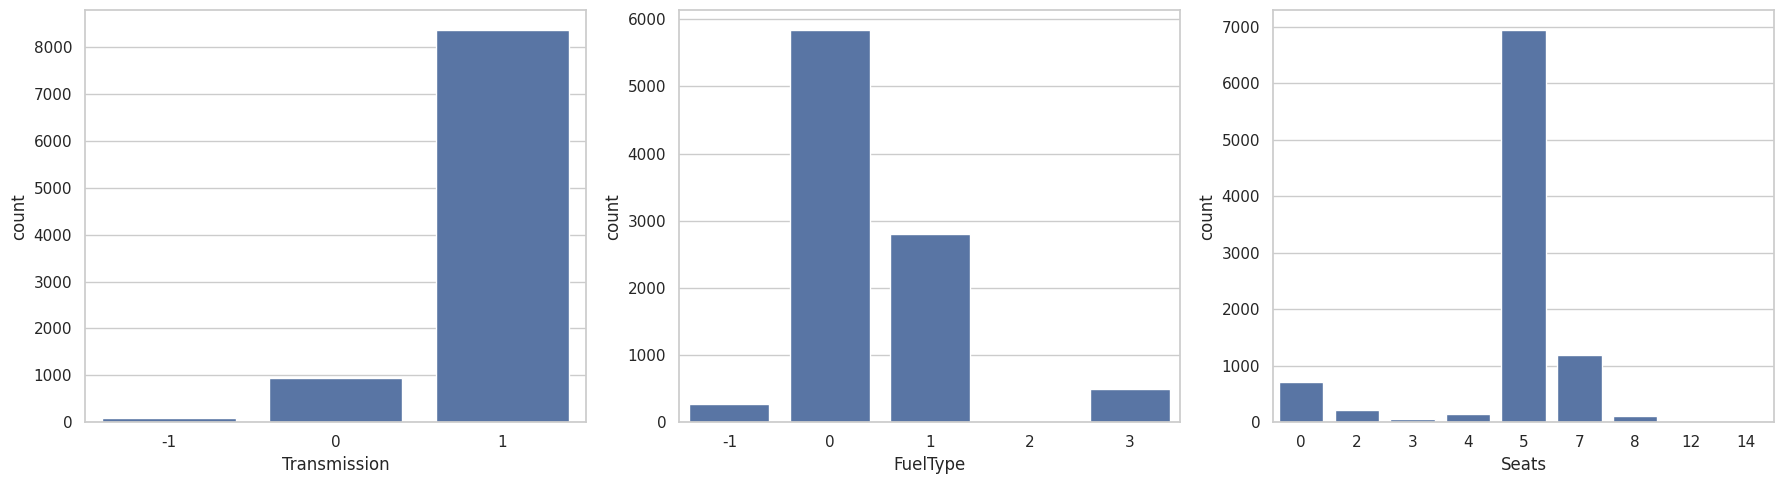

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x="Transmission", ax=ax[0])
sns.countplot(data=df, x="FuelType", ax=ax[1])
sns.countplot(data=df, x="Seats", ax=ax[2])

plt.tight_layout()
plt.show()


### Brand Coverage

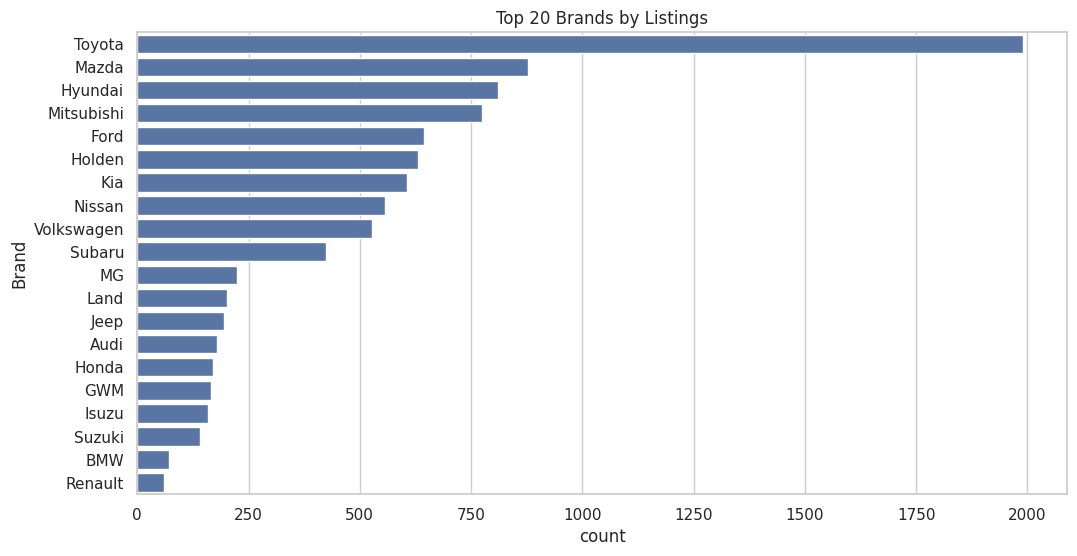

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    y="Brand",
    order=df["Brand"].value_counts().head(20).index
)
plt.title("Top 20 Brands by Listings")
plt.show()


### Filter out noisy data

In [12]:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

df = df[
    (df["Price"] <= 200_000) &
    (df["Kilometres"] <= 200_000) &
    (df["Year"] >= 2000)
].copy()

df.shape

(9407, 28)

### Compute price drop %

In [13]:

# Filter brands
brands = ["BMW", "Volkswagen","Toyota", "Honda", "Mazda","Hyundai"]
df = df[df["Brand"].isin(brands)]

# Remove extreme outliers
df = df[(df["Price"] > 1000) & (df["Kilometres"] < 300_000)]

In [14]:
# Reference price = median price below 10k km per brand
reference_price = (
    df[df["Kilometres"] <= 10_000]
    .groupby("Brand")["Price"]
    .mean()
)

# Map reference price
df["RefPrice"] = df["Brand"].map(reference_price)

# Price drop %
df["PriceDropPct"] = (df["RefPrice"] - df["Price"]) / df["RefPrice"] * 100


### Bin kms

In [15]:
bins = np.arange(0, 300001, 20000)
df["KmBin"] = pd.cut(df["Kilometres"], bins)

plot_df = (
    df.groupby(["Brand", "KmBin"])["PriceDropPct"]
    .mean()
    .reset_index()
)

# Use bin midpoints for plotting
plot_df["KmMid"] = plot_df["KmBin"].apply(lambda x: x.mid)


/tmp/ipython-input-2564993815.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Brand", "KmBin"])["PriceDropPct"]


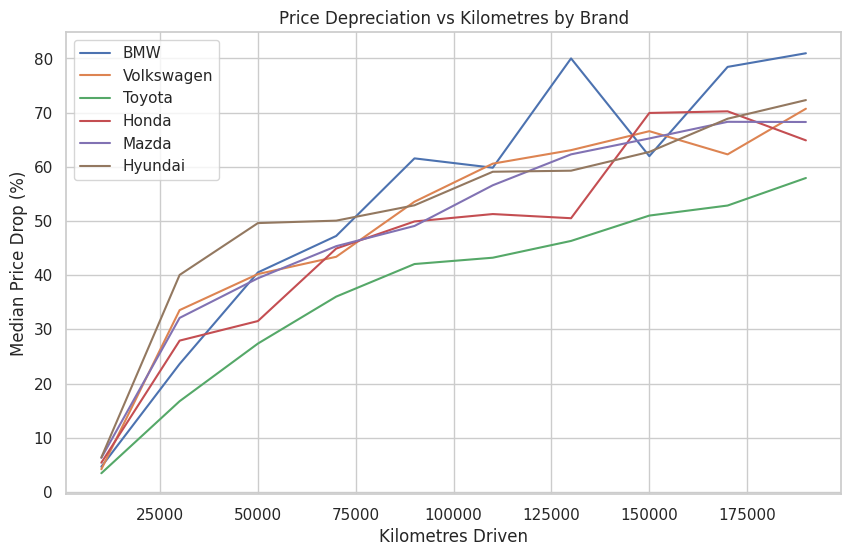

In [16]:
plt.figure(figsize=(10, 6))

for brand in brands:
    subset = plot_df[plot_df["Brand"] == brand]
    plt.plot(subset["KmMid"], subset["PriceDropPct"], label=brand)

plt.xlabel("Kilometres Driven")
plt.ylabel("Median Price Drop (%)")
plt.title("Price Depreciation vs Kilometres by Brand")
plt.legend()
plt.grid(True)
plt.show()


### Model Pipeline

In [17]:
num_cols = ["Age", "log_km","km_per_year", "FuelConsumption", "CylindersinEngine", "Seats", "age_kilometer_interaction"]
cat_cols = ["Brand", "Model", "UsedOrNew", "DriveType", "BodyType", "Transmission", "FuelType"]

X = df[num_cols + cat_cols]
y = df["y"]
groups = df["Brand"] + "||" + df["Model"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", "passthrough", num_cols)
])

model_lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42, verbose=-1)
pipe = Pipeline([("pre", preprocess), ("model", model_lgb)])

### Cross Validation

In [18]:
gkf = GroupKFold(n_splits=5)
results = {
    "MAE": [],
    "RMSE": [],
    "MAPE": [],
    "R2": []
}
print("Starting Cross-Validation...")

for tr, te in gkf.split(X, y, groups):
    # Train
    pipe.fit(X.iloc[tr], y.iloc[tr])

    # Predict log(retention) and transform back to price
    y_pred_log = pipe.predict(X.iloc[te])
    pred_retention = np.exp(y_pred_log)
    pred_price = pred_retention * df.iloc[te]["New_Price"].values

    actual_price = df.iloc[te]["Price"].values

    # Calculate metrics on the Price scale
    results["MAE"].append(mean_absolute_error(actual_price, pred_price))
    results["RMSE"].append(np.sqrt(mean_squared_error(actual_price, pred_price)))
    results["MAPE"].append(mean_absolute_percentage_error(actual_price, pred_price))
    results["R2"].append(r2_score(actual_price, pred_price))

# --- Final Metrics Summary ---
print("\n" + "="*30)
print("  MODEL PERFORMANCE SUMMARY")
print("="*30)
print(f"MAE:   A${np.mean(results['MAE']):,.2f} (+/- A${np.std(results['MAE']):,.0f})")
print(f"RMSE:  A${np.mean(results['RMSE']):,.2f}")
print(f"MAPE:  {np.mean(results['MAPE'])*100:.2f}%")
print(f"R²:    {np.mean(results['R2']):.4f}")
print("="*30)

Starting Cross-Validation...

  MODEL PERFORMANCE SUMMARY
MAE:   A$7,747.01 (+/- A$2,239)
RMSE:  A$10,160.30
MAPE:  23.94%
R²:    0.6352


### SHAP Calculation

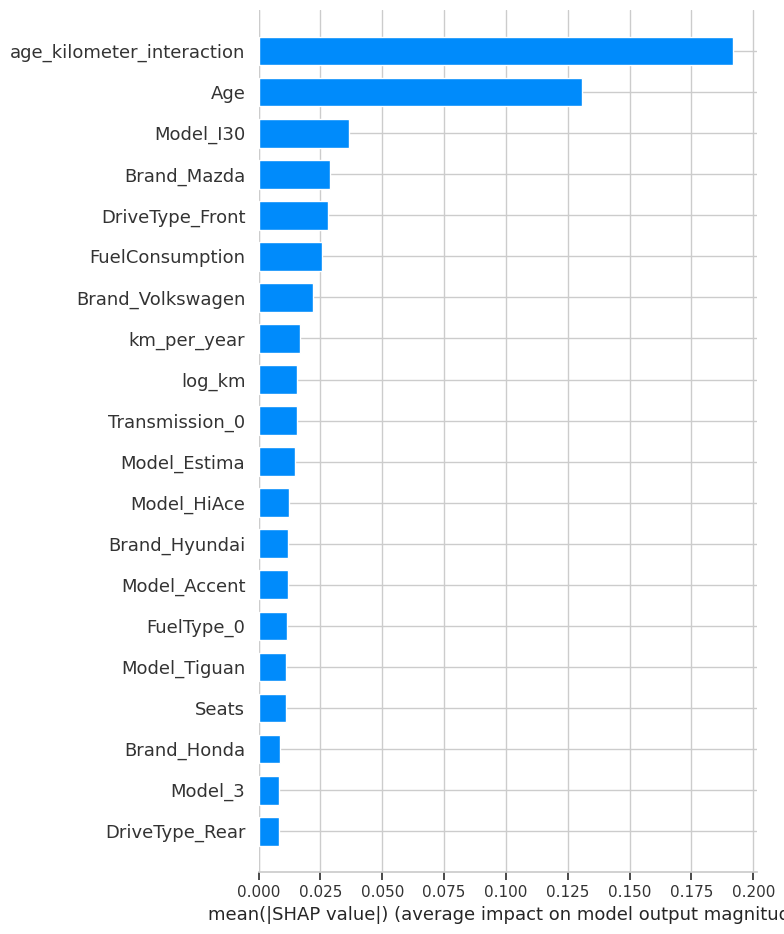

In [19]:

preprocessor = pipe.named_steps["pre"]
lgbm_model = pipe.named_steps["model"]

# Feature names after OneHotEncoding
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([cat_features, num_cols])

# Sample for SHAP efficiency
n_sample = min(1000, X.shape[0])
X_sample = X.sample(n_sample, random_state=42)
X_transformed = preprocessor.transform(X_sample)

# Calculate SHAP values
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_transformed)

# Summary Bar Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed, feature_names=all_feature_names, plot_type="bar", max_display=20)


### Brand Retention Curve Function

In [20]:
def brand_retention_curve(pipe, df, brand, kms):
    df_brand = df[df["Brand"] == brand]
    if df_brand.empty: return pd.DataFrame()

    base = df_brand.median(numeric_only=True).to_dict()
    for col in cat_cols:
        base[col] = df_brand[col].mode()[0] if not df_brand[col].mode().empty else df[col].mode()[0]

    rows = []
    for km in kms:
        r = base.copy()
        r["log_km"] = np.log1p(km)

        # Calculate km_per_year for the curve
        r["km_per_year"] = km / (base["Age"] + 1)

        r["age_kilometer_interaction"] = base["Age"] * (km / 10_000)
        rows.append(r)

    test_df = pd.DataFrame(rows)[num_cols + cat_cols]
    preds = np.exp(pipe.predict(test_df))
    return pd.DataFrame({"Kilometres": kms, "Pred_Retention": preds})

### Brand wise Retention curve

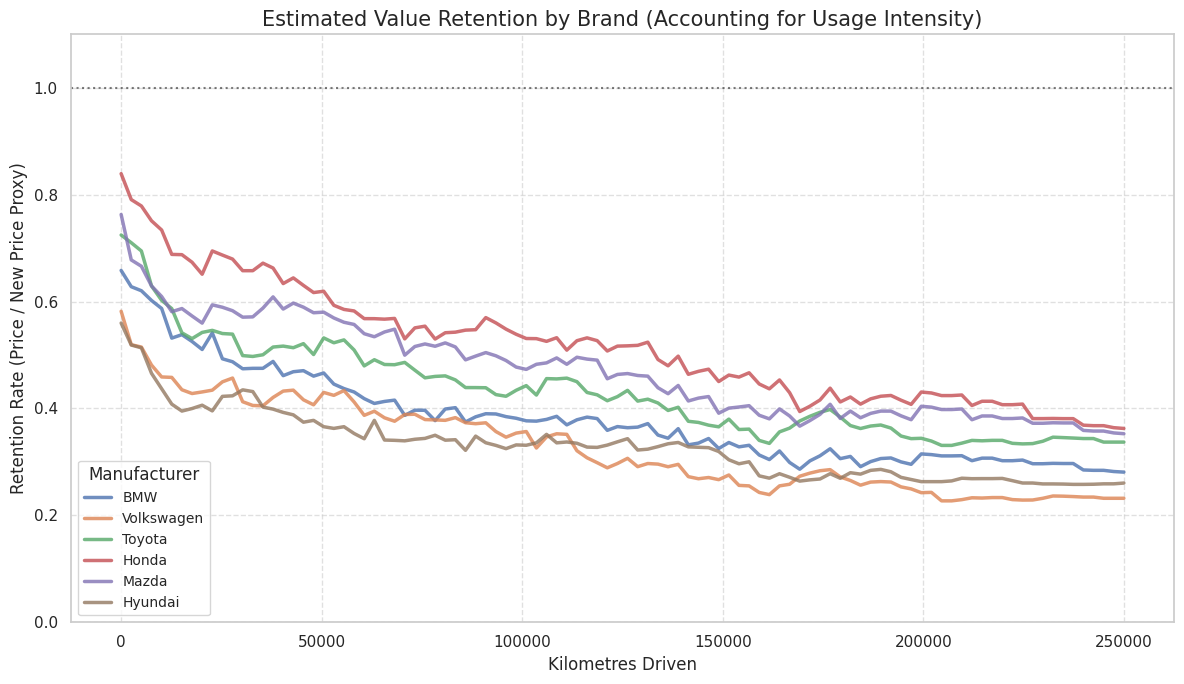

In [21]:
# 1. Define the range of kilometres (e.g., from 0 to 250k km)
kms_range = np.linspace(0, 250_000, 100)

# 2. Define the brands you want to compare
target_brands = ["BMW", "Volkswagen", "Toyota", "Honda", "Mazda", "Hyundai"]

plt.figure(figsize=(12, 7))

for brand in target_brands:
    # Use the updated function you provided
    curve = brand_retention_curve(pipe, df, brand, kms_range)

    if not curve.empty:
        plt.plot(
            curve["Kilometres"],
            curve["Pred_Retention"],
            label=brand,
            linewidth=2.5,
            alpha=0.8
        )
    else:
        print(f"Skipping {brand}: Not found in the filtered dataset.")

# 3. Formatting the plot
plt.title("Estimated Value Retention by Brand (Accounting for Usage Intensity)", fontsize=15)
plt.xlabel("Kilometres Driven", fontsize=12)
plt.ylabel("Retention Rate (Price / New Price Proxy)", fontsize=12)

# Set y-axis limits to focus on realistic depreciation (e.g., 0% to 100%+)
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Manufacturer", fontsize=10)

# Add a horizontal line at 1.0 to show the 'New' baseline
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label="Baseline (New)")

plt.tight_layout()
plt.show()

### Production Model

In [22]:
import joblib

# Save the entire pipeline (includes preprocessor and model)
joblib.dump(pipe, "final_price_pipe.joblib")

# Save the list of feature names
joblib.dump(list(X.columns), "model_features.joblib")

print("Files saved successfully as .joblib")

Files saved successfully as .joblib
